## LAM TF-score & consensus markers

In [1]:
import pandas as pd
import scanpy as sc
from pyannotables import tables
import numpy as np
import scipy as sp
import joblib
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path

In [2]:
import sys

In [3]:
sys.path.append(str(Path.home() / 'Code/sctoolkit/')

In [4]:
from sctoolkit.utils import bin_pval

In [6]:
import pandas as pd
import anndata
import numpy as np

def poor_mans_buggy_reindex(labels, adata, axis=1, fill_value=None):
    if axis == 1:
        ph = anndata.AnnData(np.ones([0, len(labels)]), var=pd.DataFrame(index=labels))
        ret = anndata.concat([adata, ph], join='outer', axis=0, fill_value=fill_value)
        return ret[:, labels].copy()
    else:
        ph = anndata.AnnData(np.ones([len(labels), 0]), obs=pd.DataFrame(index=labels))   
        ret = anndata.concat([adata, ph], join='outer', axis=1, fill_value=fill_value)
        return ret[labels].copy()    

In [ ]:
lamdb = sc.read('lamdb-with-predictions.h5ad')

## Per dataset ops: TF scoring & zscore & coexpression tests

In [5]:
import pandas as pd
import fisher
import dorothea

reg = dorothea.load_regulons(['A', 'B', 'C'])

In [ ]:
ads = []
pvals = {}
ors = {}
dorothea_ads = []
dorothea_score_df = []
dorothea_mean_df = []

lam_mac_de_dfs = []

for dataset in tqdm(lamdb.obs.study_desc.cat.categories):
    ad = lamdb[lamdb.obs.study_desc == dataset].copy()
    
    # lam DE
    sc.tl.rank_genes_groups(ad, 'lam_02', use_raw=False, reference='Mac', groups=['LAM'], method='t-test')
    lam_de = sc.get.rank_genes_groups_df(ad, group='LAM')
    lam_mac_de_dfs.append(lam_de.assign(dataset=dataset))
    
    # zscore
    ad.layers['scaled'] = ad.X.copy()
    sc.pp.scale(ad, layer='scaled', max_value=10)
    
    # tf score
    #dorothea.run(ad, reg)
    dorothea.run(
        ad, reg,
        center=True,  # Center gene expression by mean per cell
        num_perm=0, # Simulate m random activities
        norm=True,    # Normalize by number of edges to correct for large regulons
        scale=True,   # Scale values per feature so that values can be compared across cells
        use_raw=False, # Use lognorm gene expression
        min_size=5,   # TF with less than 5 targets will be ignored
    )

    dscores = dorothea.extract(ad)
    dorothea_ads.append(dscores)
    
    means = pd.DataFrame(dscores.X, index=dscores.obs_names, columns=dscores.var_names).groupby(ad.obs.lam_02).mean().reset_index().melt('lam_02', value_name='mean')
    dorothea_mean_df.append(means.assign(study=dataset))

    d_sub = dscores[dscores.obs.lam_02!='non-mac'].copy()
    sc.tl.rank_genes_groups(d_sub, 'lam_02')
    d_sub = sc.get.rank_genes_groups_df(d_sub, group=None)
    dorothea_score_df.append(d_sub.assign(study=dataset))
            
    ads.append(ad)

## TF scoring

In [22]:
dorothea_scores = pd.concat(dorothea_score_df, axis=0)
dorothea_scores['neglogfdr'] = -np.log10(dorothea_scores.pvals_adj+1e-30)
dorothea_scores['significant'] = (dorothea_scores.pvals_adj<0.05) & (dorothea_scores.scores>0)
dorothea_scores.drop_duplicates(inplace=True)

dorothea_means = pd.concat(dorothea_mean_df, axis=0)
dorothea_means = dorothea_means.rename(columns={'tf': 'names', 'lam_02': 'group'})
dorothea_means.drop_duplicates(inplace=True)

dorothea_scores = dorothea_scores.merge(dorothea_means)
dorothea_scores

,group,names,scores,logfoldchanges,pvals,pvals_adj,study,neglogfdr,significant,mean
0,LAM,PPARG,20.180195,4.453095,3.023263e-33,4.413964e-31,Adipose (omental) [Jaitin et al.],29.841217,True,3.022064
1,LAM,HIF1A,18.141350,NaN,1.479023e-31,1.439583e-29,Adipose (omental) [Jaitin et al.],28.812597,True,1.106188
2,LAM,MYC,17.536533,NaN,4.149795e-29,3.029350e-27,Adipose (omental) [Jaitin et al.],26.518507,True,1.477956
3,LAM,RUNX1,16.567270,4.316205,5.172031e-28,2.517055e-26,Adipose (omental) [Jaitin et al.],25.599090,True,2.563878
4,LAM,CREB3,14.742531,4.407361,1.320777e-25,4.820836e-24,Adipose (omental) [Jaitin et al.],23.316878,True,1.475062
...,...,...,...,...,...,...,...,...,...,...
18683,Mac,NR2C2,-12.553004,1.402836,7.686761e-27,3.206477e-25,Testis [Tan et al.],24.493970,False,-1.082009
18684,Mac,USF1,-13.223304,-3.316339,2.169129e-26,7.917320e-25,Testis [Tan et al.],24.101421,False,0.535637
18685,Mac,NFYB,-13.524392,NaN,1.797349e-30,1.064615e-28,Testis [Tan et al.],27.968747,False,-0.405924
18686,Mac,RUNX1,-13.792566,-2.581039,7.432903e-32,1.085204e-29,Testis [Tan et al.],28.926207,False,0.987561


In [23]:
dorothea_scores.group.unique()

array(['LAM', 'Mac'], dtype=object)

In [25]:
from plotnine import *

In [32]:
dorothea_scores.names.nunique()

292

In [33]:
diff_df = dorothea_scores[(dorothea_scores.group=='LAM') & (dorothea_scores.study.isin(studies))].pivot(index='study', columns='names', values='mean') - dorothea_scores[(dorothea_scores.group=='Mac') & (dorothea_scores.study.isin(studies))].pivot(index='study', columns='names', values='mean')

In [ ]:
df = diff_df.mean(0).sort_values(ascending=False).reset_index().rename(columns={0: 'diff'})
df['names'] = pd.Categorical(df['names'], categories=df['names'])

In [35]:
topbottom10 = df.head(10).names.tolist() + df.tail(10).names.tolist()
topbottom10

['RUNX1',
 'PPARG',
 'USF1',
 'ERG',
 'HIF1A',
 'NR1H3',
 'USF2',
 'SMAD1',
 'MYC',
 'ETV4',
 'RUNX3',
 'POU5F1',
 'THAP11',
 'NANOG',
 'TWIST1',
 'PDX1',
 'POU4F2',
 'MAFG',
 'HNF1A',
 'SOX2']

In [38]:
%load_ext rpy2.ipython

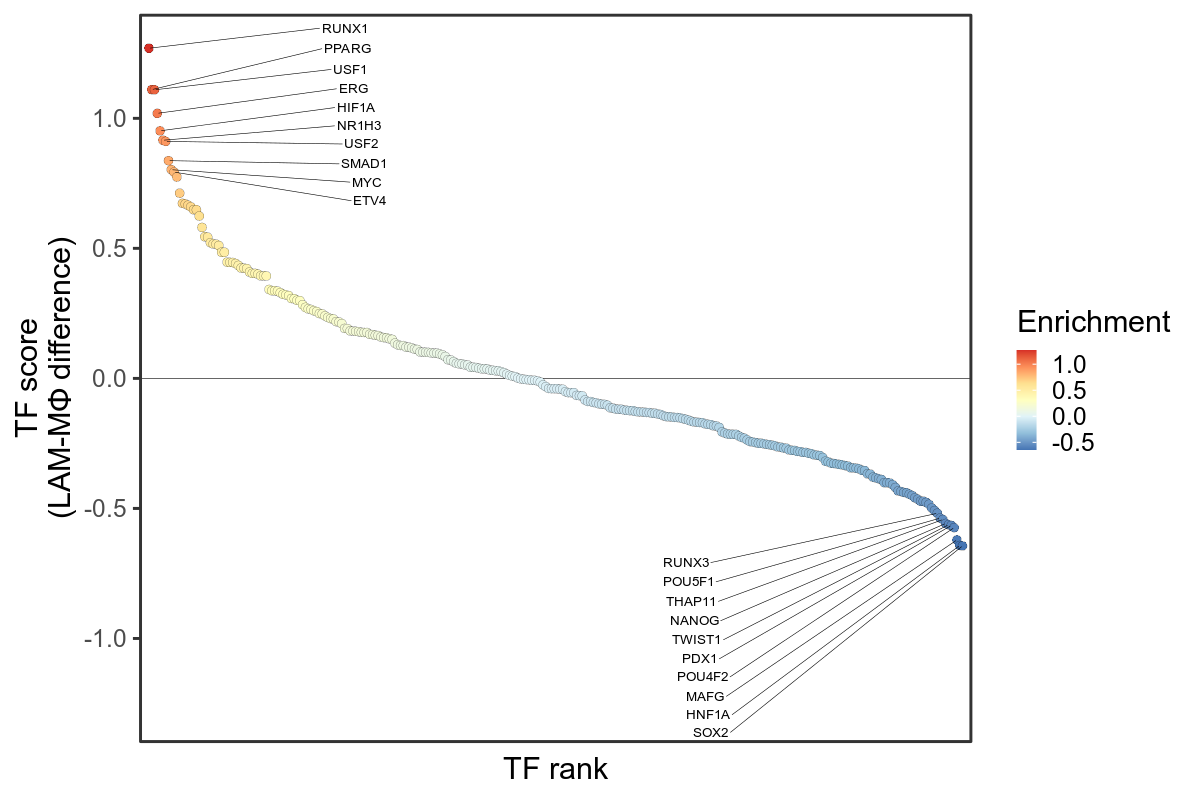

In [39]:
%%R -i df -i topbottom10 -u in -w 6 -h 4 -r 200 -p 5


topbottom10 = unlist(topbottom10)
#print(topbottom10)

library(ggplot2)
library(ggrepel)

g = ggplot(aes(x=names, y=diff), data=df) +
    #geom_bar(stat='identity', width=0.5, fill='black') + 
    geom_hline(yintercept=0, size=0.1) +    
    geom_point(aes(fill=diff), shape=21, color='black', stroke=0.05, size=1.5) +
    #geom_path(color='black', fill='black') +

    geom_text_repel(
        aes(label=names), 
        size=1.7,
        data=df[df$names %in% (topbottom10[1:10]),],
        nudge_x=70,
        direction='y',
        segment.size=0.1,
    ) + 
    geom_text_repel(
        aes(label=names), 
        size=1.7,
        data=df[df$names %in% (topbottom10[11:20]),],
        nudge_x=-90,
        nudge_y=-0.7,
        direction='y',
        segment.size=0.1,        
    ) +     
    labs(y='TF score\n(LAM-MΦ difference)', x='TF rank', fill='Enrichment')+
    theme_bw() +
    coord_cartesian(clip = "off", ylim=c(-max(abs(df$diff)), max(abs(df$diff)))) +
    theme(
        axis.text.x=element_blank(),
        panel.grid.major=element_blank(),
        panel.grid.minor=element_blank(),        
        axis.ticks.x=element_blank(),
    ) + 
    scale_fill_distiller(palette='RdYlBu') +
    scale_x_discrete(expand = expansion(add=3)
)
    
ggsave('../immune-atlas-preprocessing/figure/Figure3H.pdf', width=6, height=4, device=cairo_pdf)

g

In [40]:
top_lam_tfs = diff_df.mean(0).sort_values(ascending=False)[:5].index.values
top_mac_tfs = diff_df.mean(0).sort_values(ascending=True)[:5].index.values

In [41]:
top_lam_tfs

array(['RUNX1', 'PPARG', 'USF1', 'ERG', 'HIF1A'], dtype=object)

In [42]:
top_mac_tfs

array(['SOX2', 'HNF1A', 'MAFG', 'POU4F2', 'PDX1'], dtype=object)

## Per-cell info and plots (e.g. boxplots)

In [ ]:
dad = sc.concat(dorothea_ads)
dad = dad[dad.obs.study_desc.isin(studies)].copy()
dad._sanitize()

## LAM barplots

In [44]:
top_lam_tfs

array(['RUNX1', 'PPARG', 'USF1', 'ERG', 'HIF1A'], dtype=object)

In [45]:
top_lam_tfs = ['PPARG', 'NR1H3', 'USF1']

In [46]:
percell_df = pd.concat([pd.DataFrame(dad.X, index=dad.obs_names, columns=dad.var_names)[top_lam_tfs], dad.obs], axis=1).melt(['study_desc', 'lam_02'], value_vars=top_lam_tfs, value_name='score', var_name='tf')
percell_df.tf = pd.Categorical(percell_df.tf, categories=top_lam_tfs)
percell_df.study_desc = pd.Categorical(percell_df.study_desc, categories=studies[::-1])

In [47]:
lam_pvals =  dorothea_scores[(dorothea_scores.group == 'LAM') & (dorothea_scores.names.isin(top_lam_tfs)) & (dorothea_scores.study.isin(studies)) & (dorothea_scores.scores>0)]
lam_pvals['stars'] = bin_pval(lam_pvals.pvals_adj)
lam_pvals.rename(columns={'names': 'tf'}, inplace=True)

text_pos = percell_df.groupby(['tf'])[['score']].max() - ((percell_df.groupby(['tf'])[['score']].max() - percell_df.groupby(['tf'])[['score']].min())*.05)
text_pos = text_pos.reset_index().rename(columns={'score': 'textpos'})

lam_pvals = lam_pvals.merge(text_pos).rename(columns={'study': 'study_desc'})
lam_pvals.stars.loc[lam_pvals.stars == '.'] = np.nan
lam_pvals.tf = pd.Categorical(lam_pvals.tf, categories=top_lam_tfs)

lam_pvals

<ipython-input-47-34d798f72a75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,group,tf,scores,logfoldchanges,pvals,pvals_adj,study_desc,neglogfdr,significant,mean,stars,textpos
0,LAM,PPARG,20.180195,4.453095,3.023263e-33,4.413964e-31,Adipose (omental) [Jaitin et al.],29.841217,True,3.022064,***,6.614793
1,LAM,PPARG,13.079450,3.062182,2.002910e-21,7.310620e-20,Adipose [Muus et al.],19.136046,True,1.650559,***,6.614793
2,LAM,PPARG,7.932191,1.945604,1.754861e-12,3.416130e-11,Artery (atherosclerotic lesions) [Wirka et al.],10.466466,True,1.381043,***,6.614793
3,LAM,PPARG,43.769287,2.340506,0.000000e+00,0.000000e+00,"Artery (atherosclerotic plaques) [Alsaigh, et ...",30.000000,True,2.089252,***,6.614793
4,LAM,PPARG,11.126584,4.087138,5.923272e-22,6.405909e-21,CNS (temporal lobe epilepsy) [Tome-Garcia et al.],20.193419,True,1.141966,***,6.614793
...,...,...,...,...,...,...,...,...,...,...,...,...
60,LAM,NR1H3,4.645892,NaN,8.203186e-04,2.086563e-02,Skeletal muscle (Left rectus abdominus) [De Mi...,1.680568,True,1.659035,*,7.441111
61,LAM,NR1H3,2.814260,1.779525,6.036738e-03,3.750484e-02,Skin (Acne) [Hughes et al.],1.425913,True,1.303922,*,7.441111
62,LAM,NR1H3,4.381729,1.191368,1.902922e-05,2.415883e-04,Skin (Leprosy) [Hughes et al.],3.616924,True,1.266262,***,7.441111
63,LAM,NR1H3,5.286221,NaN,1.565518e-06,7.256053e-06,Skin (atopic dermatitis) [Rojahn et al.],5.139300,True,0.423596,***,7.441111


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 7 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../immune-atlas-preprocessing/figure/Figure3I-1.pdf
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 1 rows containing missing values.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 1 rows containing missing values.


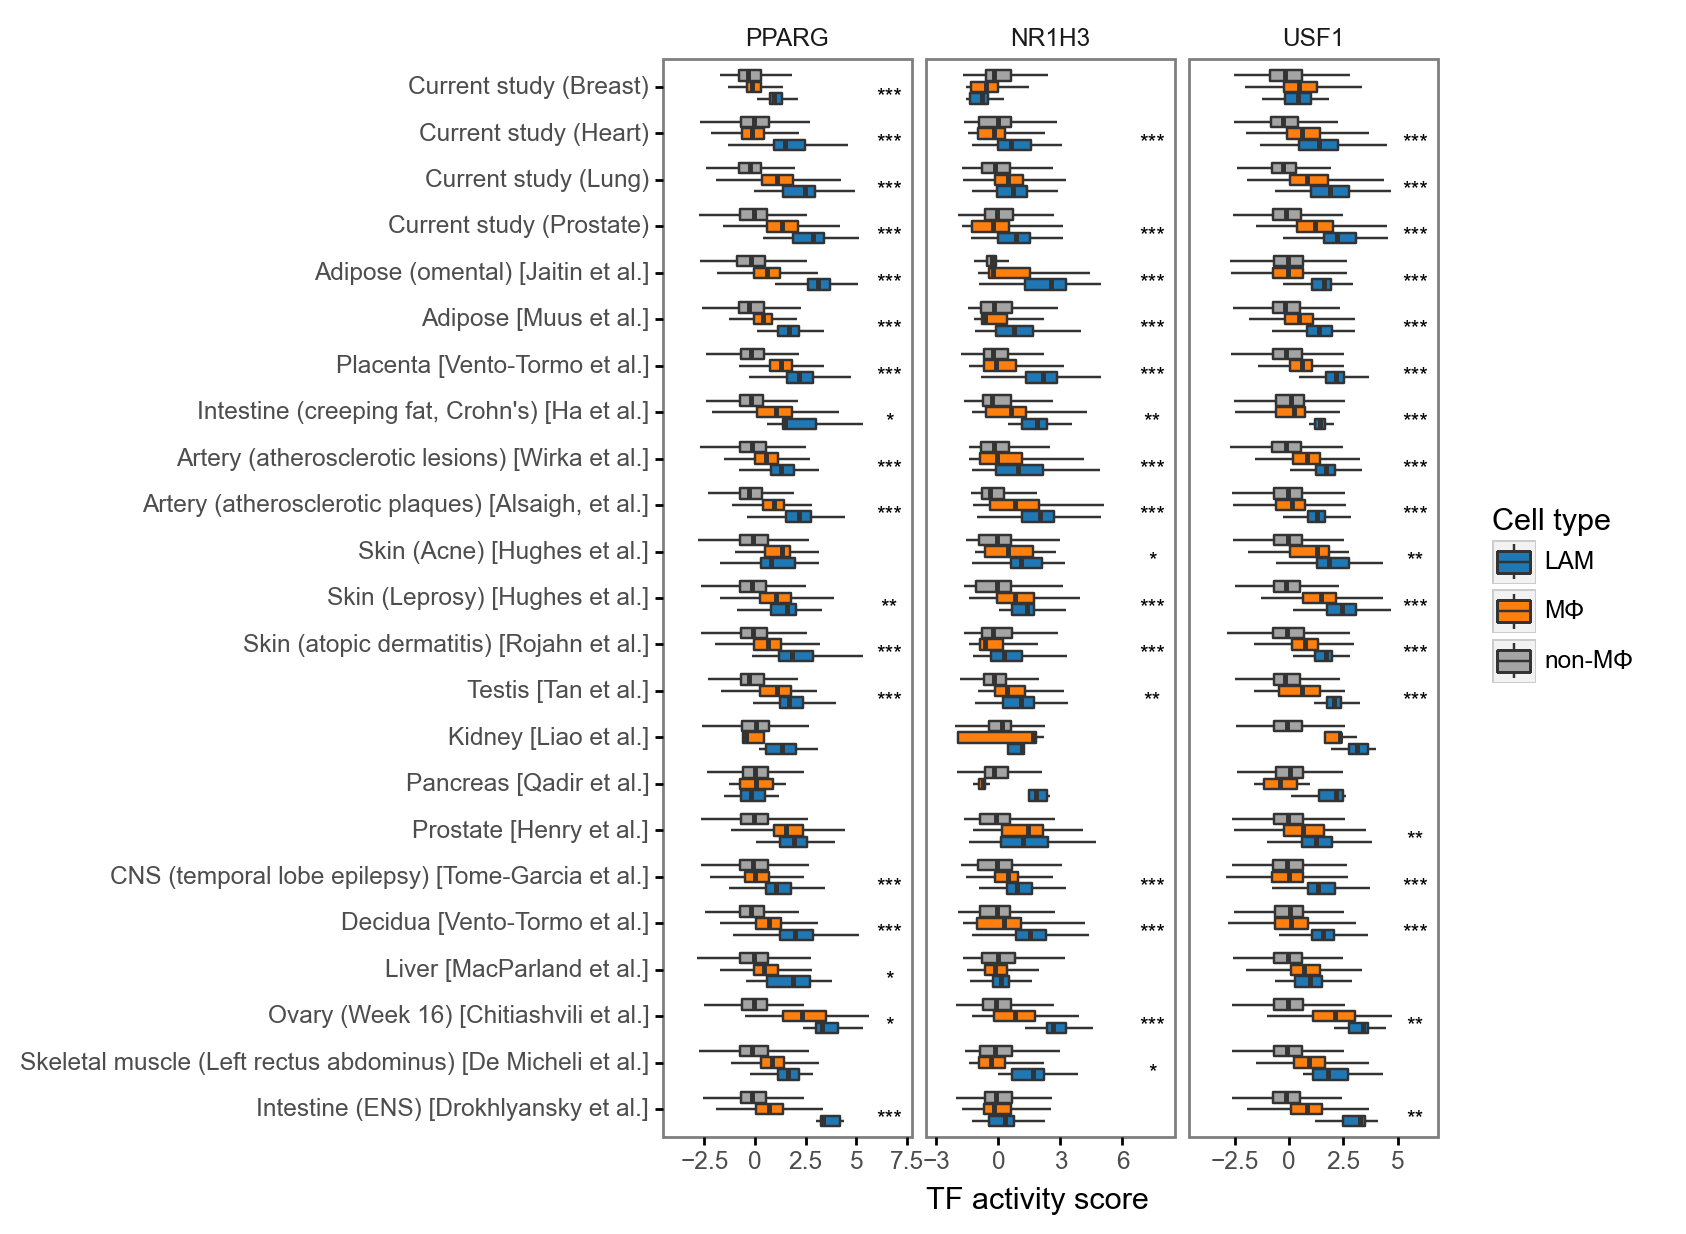

<ggplot: (8747456584795)>

In [51]:
g = (
    ggplot(aes(x='study_desc', y='score'), data=percell_df) +
    geom_boxplot(aes(fill='lam_02'), outlier_shape='') + 
    geom_text(aes(y='textpos', label='stars'), data=lam_pvals, size=8, nudge_x=-0.2) + 
    facet_wrap('tf', nrow=1, scales='free_x') +
    coord_flip() +
    labs(y='TF activity score', x='', fill='Cell type')+
    scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#A4A4A4'], labels=['LAM', 'MΦ', 'non-MΦ']) +     
    theme_bw() + 
    theme(
        strip_background=element_blank(),
        #axis_text_x=element_text(rotation=45, hjust=1), 
        text=element_text(family='Arial'),
        panel_grid=element_blank(),
        figure_size=(5,7),
    )
)

g

In [52]:
lam_pvals

,group,tf,scores,logfoldchanges,pvals,pvals_adj,study_desc,neglogfdr,significant,mean,stars,textpos
0,LAM,PPARG,20.180195,4.453095,3.023263e-33,4.413964e-31,Adipose (omental) [Jaitin et al.],29.841217,True,3.022064,***,6.614793
1,LAM,PPARG,13.079450,3.062182,2.002910e-21,7.310620e-20,Adipose [Muus et al.],19.136046,True,1.650559,***,6.614793
2,LAM,PPARG,7.932191,1.945604,1.754861e-12,3.416130e-11,Artery (atherosclerotic lesions) [Wirka et al.],10.466466,True,1.381043,***,6.614793
3,LAM,PPARG,43.769287,2.340506,0.000000e+00,0.000000e+00,"Artery (atherosclerotic plaques) [Alsaigh, et ...",30.000000,True,2.089252,***,6.614793
4,LAM,PPARG,11.126584,4.087138,5.923272e-22,6.405909e-21,CNS (temporal lobe epilepsy) [Tome-Garcia et al.],20.193419,True,1.141966,***,6.614793
...,...,...,...,...,...,...,...,...,...,...,...,...
60,LAM,NR1H3,4.645892,NaN,8.203186e-04,2.086563e-02,Skeletal muscle (Left rectus abdominus) [De Mi...,1.680568,True,1.659035,*,7.441111
61,LAM,NR1H3,2.814260,1.779525,6.036738e-03,3.750484e-02,Skin (Acne) [Hughes et al.],1.425913,True,1.303922,*,7.441111
62,LAM,NR1H3,4.381729,1.191368,1.902922e-05,2.415883e-04,Skin (Leprosy) [Hughes et al.],3.616924,True,1.266262,***,7.441111
63,LAM,NR1H3,5.286221,NaN,1.565518e-06,7.256053e-06,Skin (atopic dermatitis) [Rojahn et al.],5.139300,True,0.423596,***,7.441111


In [53]:
lam_pvals.groupby('tf')[['pvals_adj']].agg(lambda x: sp.stats.combine_pvalues(x)[1])

/home/gokcen/.miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:7661: RuntimeWarning: divide by zero encountered in log


,pvals_adj
tf,
PPARG,0.0
NR1H3,0.0
USF1,0.0


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 3 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../immune-atlas-preprocessing/figure/Figure-12-F-upper.pdf


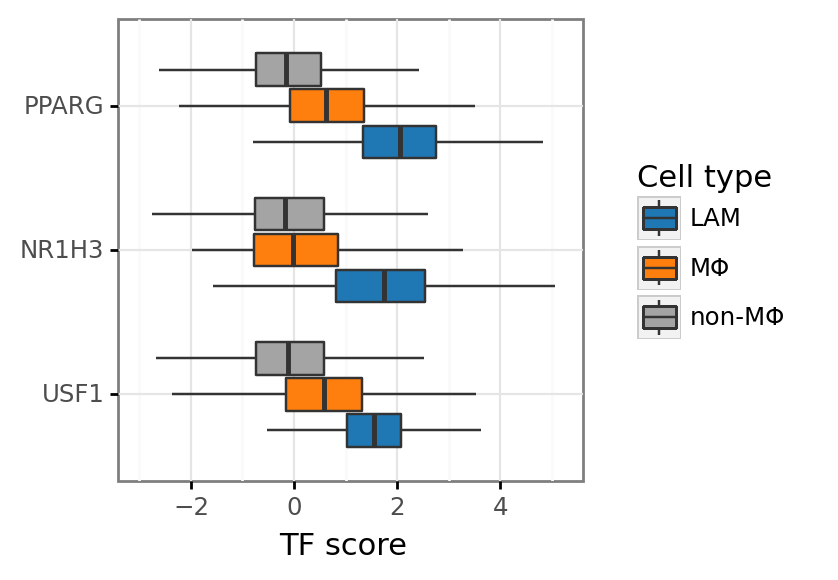

<ggplot: (8747456445230)>

In [54]:
percell_df.tf = pd.Categorical(percell_df.tf, categories=top_lam_tfs[::-1])

g = (
    ggplot(aes(x='tf', y='score'), data=percell_df) +
    geom_boxplot(aes(fill='lam_02'), outlier_shape='') + 
    scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#A4A4A4'], labels=['LAM', 'MΦ', 'non-MΦ']) +         
    coord_flip(ylim=[-3,5.2]) +
    labs(y='TF score', x='', fill='Cell type')+
    theme_bw() + 
    theme(figure_size=(3,3))
)

ggsave(g, '../immune-atlas-preprocessing/figure/Figure-S12-F-upper.pdf')

g

## Mac plots

In [55]:
top_mac_tfs

array(['SOX2', 'HNF1A', 'MAFG', 'POU4F2', 'PDX1'], dtype=object)

In [56]:
top_mac_tfs = ['RUNX3', 'TWIST1']

In [57]:
percell_df = pd.concat([pd.DataFrame(dad.X, index=dad.obs_names, columns=dad.var_names)[top_mac_tfs], dad.obs], axis=1).melt(['study_desc', 'lam_02'], value_vars=top_mac_tfs, value_name='score', var_name='tf')
percell_df.tf = pd.Categorical(percell_df.tf, categories=top_mac_tfs)
percell_df.study_desc = pd.Categorical(percell_df.study_desc, categories=studies[::-1])

In [58]:
mac_pvals =  dorothea_scores[(dorothea_scores.group == 'Mac') & (dorothea_scores.names.isin(top_mac_tfs)) & (dorothea_scores.study.isin(studies)) & (dorothea_scores.scores>0)]
mac_pvals['stars'] = bin_pval(mac_pvals.pvals_adj)
mac_pvals.rename(columns={'names': 'tf'}, inplace=True)
mac_pvals

<ipython-input-58-a5405ea72445>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,group,tf,scores,logfoldchanges,pvals,pvals_adj,study,neglogfdr,significant,mean,stars
385,Mac,TWIST1,3.742006,1.395072,3.047424e-04,4.943599e-04,Adipose (omental) [Jaitin et al.],3.305957,True,0.520562,***
403,Mac,RUNX3,2.329329,-0.972925,2.237269e-02,2.956030e-02,Adipose (omental) [Jaitin et al.],1.529291,True,-0.210542,*
1465,Mac,TWIST1,13.710869,NaN,1.940822e-23,9.445331e-22,Adipose [Muus et al.],21.024783,True,0.451106,***
1529,Mac,RUNX3,3.864898,-0.806695,2.256581e-04,5.729752e-04,Adipose [Muus et al.],3.241864,True,-0.391371,***
2104,Mac,RUNX3,2.778005,-1.994410,6.303532e-03,1.496448e-02,Artery (atherosclerotic lesions) [Wirka et al.],1.824938,True,-0.069216,*
2135,Mac,TWIST1,1.736161,0.814039,8.511579e-02,1.412148e-01,Artery (atherosclerotic lesions) [Wirka et al.],0.850120,False,0.417530,
2628,Mac,TWIST1,52.474117,NaN,0.000000e+00,0.000000e+00,"Artery (atherosclerotic plaques) [Alsaigh, et ...",30.000000,True,0.786473,***
2763,Mac,RUNX3,9.804868,-0.429211,2.003289e-22,3.015259e-22,"Artery (atherosclerotic plaques) [Alsaigh, et ...",21.520675,True,-0.492123,***
5582,Mac,TWIST1,7.523824,NaN,3.444400e-12,1.622201e-11,CNS (temporal lobe epilepsy) [Tome-Garcia et al.],10.789895,True,0.369146,***
5679,Mac,RUNX3,2.640905,NaN,8.893348e-03,1.266760e-02,CNS (temporal lobe epilepsy) [Tome-Garcia et al.],1.897306,True,0.015774,*


In [59]:
text_pos = percell_df.groupby(['tf'])[['score']].max() - ((percell_df.groupby(['tf'])[['score']].max() - percell_df.groupby(['tf'])[['score']].min())*.05)
text_pos = text_pos.reset_index().rename(columns={'score': 'textpos'})

mac_pvals = mac_pvals.merge(text_pos).rename(columns={'study': 'study_desc'})
mac_pvals.stars.loc[mac_pvals.stars == '.'] = np.nan
mac_pvals.tf = pd.Categorical(mac_pvals.tf, categories=top_mac_tfs)

mac_pvals

,group,tf,scores,logfoldchanges,pvals,pvals_adj,study_desc,neglogfdr,significant,mean,stars,textpos
0,Mac,TWIST1,3.742006,1.395072,3.047424e-04,4.943599e-04,Adipose (omental) [Jaitin et al.],3.305957,True,0.520562,***,6.186376
1,Mac,TWIST1,13.710869,NaN,1.940822e-23,9.445331e-22,Adipose [Muus et al.],21.024783,True,0.451106,***,6.186376
2,Mac,TWIST1,1.736161,0.814039,8.511579e-02,1.412148e-01,Artery (atherosclerotic lesions) [Wirka et al.],0.850120,False,0.417530,,6.186376
3,Mac,TWIST1,52.474117,NaN,0.000000e+00,0.000000e+00,"Artery (atherosclerotic plaques) [Alsaigh, et ...",30.000000,True,0.786473,***,6.186376
4,Mac,TWIST1,7.523824,NaN,3.444400e-12,1.622201e-11,CNS (temporal lobe epilepsy) [Tome-Garcia et al.],10.789895,True,0.369146,***,6.186376
5,Mac,TWIST1,2.351599,1.911715,2.205092e-02,4.952975e-02,Current study (Heart),1.305134,True,0.500369,*,6.186376
6,Mac,TWIST1,2.287856,NaN,2.466790e-02,5.673406e-02,Current study (Prostate),1.246156,False,0.090606,NaN,6.186376
7,Mac,TWIST1,14.013362,NaN,1.622260e-37,1.029782e-36,Decidua [Vento-Tormo et al.],30.000000,True,0.507115,***,6.186376
8,Mac,TWIST1,0.246436,0.282394,8.108094e-01,8.609322e-01,Intestine (ENS) [Drokhlyansky et al.],0.065031,False,0.276763,,6.186376
9,Mac,TWIST1,2.555227,NaN,2.465034e-02,9.997084e-02,"Intestine (creeping fat, Crohn's) [Ha et al.]",1.000127,False,0.295941,NaN,6.186376


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.2 x 7 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../immune-atlas-preprocessing/figure/Figure3I-2.pdf
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 2 rows containing missing values.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_text : Removed 2 rows containing missing values.


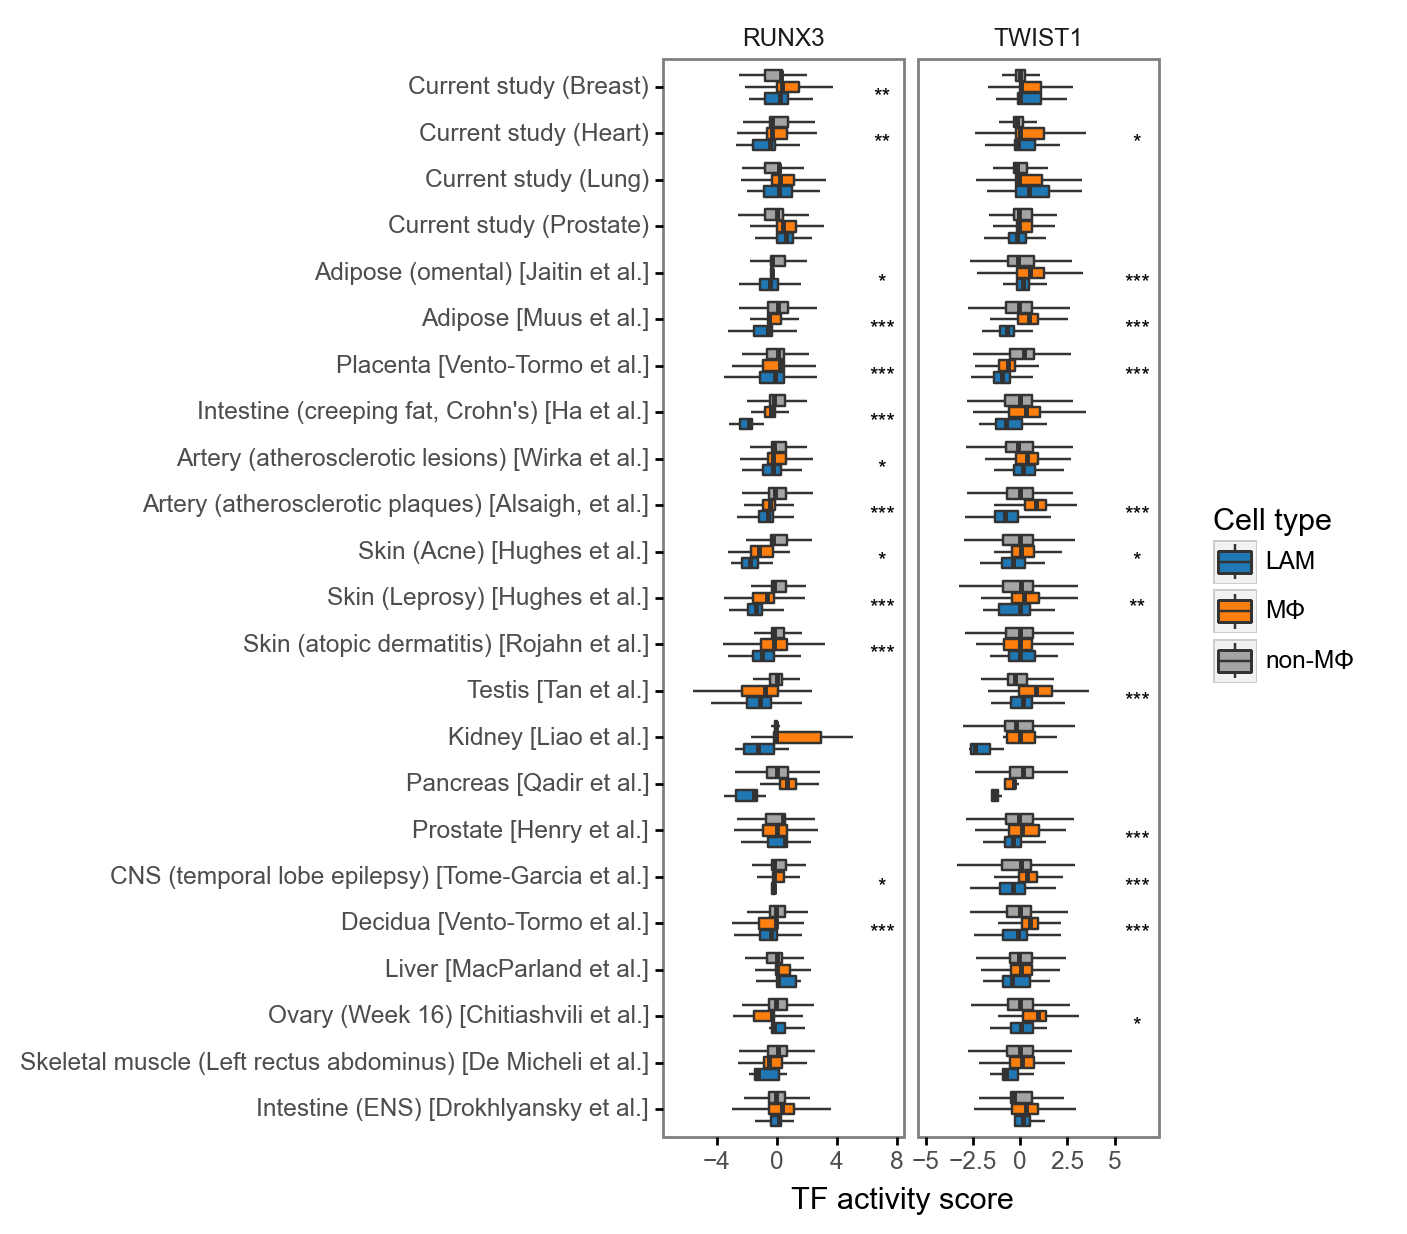

<ggplot: (8747745679222)>

In [61]:
g = (
    ggplot(aes(x='study_desc', y='score'), data=percell_df) +
    geom_boxplot(aes(fill='lam_02'), outlier_shape='') + 
    geom_text(aes(y='textpos', label='stars'), data=mac_pvals, size=8, nudge_x=-0.2) + 
    facet_wrap('tf', nrow=1, scales='free_x') +
    #scale_fill_cmap('Blues') + 
    #scale_color_manual(values={False: '#808080', True: '#990E1D'}) + 
    coord_flip() +
    labs(y='TF activity score', x='', fill='Cell type')+
    scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#A4A4A4'], labels=['LAM', 'MΦ', 'non-MΦ']) +         
    theme_bw() + 
    theme(
        #axis_text_x=element_text(rotation=45, hjust=1), 
        strip_background=element_blank(),        
        text=element_text(family='Arial'),    
        panel_grid=element_blank(),
        figure_size=(3.2,7),
    )
)

ggsave(g, '../immune-atlas-preprocessing/figure/Figure3I-2.pdf')
g

In [62]:
mac_pvals.groupby('tf')[['pvals_adj']].agg(lambda x: sp.stats.combine_pvalues(x)[1])

/home/gokcen/.miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:7661: RuntimeWarning: divide by zero encountered in log


,pvals_adj
tf,
RUNX3,1.403239e-39
TWIST1,0.000000e+00


/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 2 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../immune-atlas-preprocessing/figure/Figure-S12-F-lower.pdf


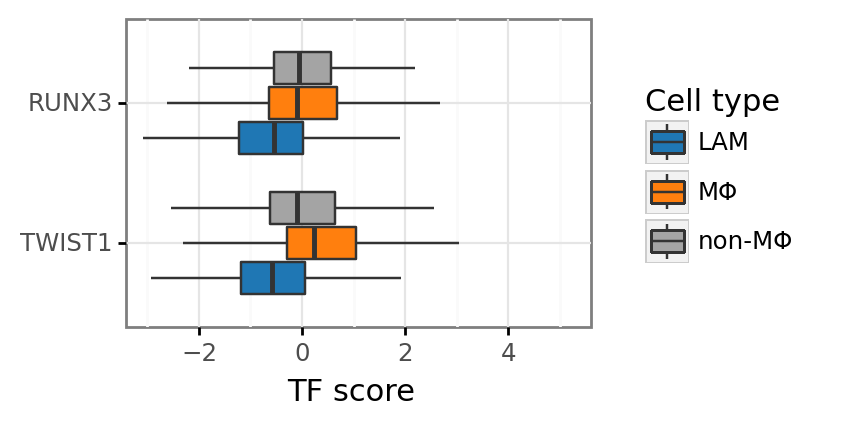

<ggplot: (8747457175050)>

In [63]:
percell_df.tf = pd.Categorical(percell_df.tf, categories=top_mac_tfs[::-1])

g = (
    ggplot(aes(x='tf', y='score'), data=percell_df) +
    geom_boxplot(aes(fill='lam_02'), outlier_shape='') + 
    scale_fill_manual(values=['#1f77b4', '#ff7f0e', '#A4A4A4'], labels=['LAM', 'MΦ', 'non-MΦ']) +         
    coord_flip(ylim=[-3,5.2]) +
    labs(y='TF score', x='', fill='Cell type')+
    theme_bw() + 
    theme(figure_size=(3,2))
)

ggsave(g, '../immune-atlas-preprocessing/figure/Figure-S12-F-lower.pdf')
g

## LAM-MAC DE

In [93]:
lam_mac_de = pd.concat(lam_mac_de_dfs, axis=0).reset_index(drop=True)

In [94]:
studies = [
    'Adipose (omental) [Jaitin et al.]',
    'Adipose [Muus et al.]',
    'Placenta [Vento-Tormo et al.]',
    'Intestine (creeping fat, Crohn\'s) [Ha et al.]',

    'Artery (atherosclerotic lesions) [Wirka et al.]',
    'Artery (atherosclerotic plaques) [Alsaigh, et al.]',
    
    'Skin (Acne) [Hughes et al.]',
    'Skin (Leprosy) [Hughes et al.]',    
    'Skin (atopic dermatitis) [Rojahn et al.]',    

    'Testis [Tan et al.]',
    'Kidney [Liao et al.]',    
    'Pancreas [Qadir et al.]',
    'Prostate [Henry et al.]',
    'CNS (temporal lobe epilepsy) [Tome-Garcia et al.]',
    'Decidua [Vento-Tormo et al.]',    
    'Liver [MacParland et al.]',
    'Ovary (Week 16) [Chitiashvili et al.]',
    'Skeletal muscle (Left rectus abdominus) [De Micheli et al.]',
    'Intestine (ENS) [Drokhlyansky et al.]',
]

In [96]:
lam_mac_de = lam_mac_de[(lam_mac_de.logfoldchanges>.5) & (lam_mac_de.pvals_adj<0.1)]
lam_mac_de

,names,scores,logfoldchanges,pvals,pvals_adj,dataset
0,FABP5,24.659395,6.200023,1.524167e-39,2.440330e-36,Adipose (omental) [Jaitin et al.]
1,SH3BGRL3,23.833694,4.355762,5.270307e-42,9.282064e-39,Adipose (omental) [Jaitin et al.]
2,LIPA,22.691557,5.103033,1.477570e-37,2.001767e-34,Adipose (omental) [Jaitin et al.]
3,LGALS3,22.506346,5.200631,4.268801e-37,5.012142e-34,Adipose (omental) [Jaitin et al.]
4,S100A11,21.754816,3.133957,9.893448e-44,1.936038e-40,Adipose (omental) [Jaitin et al.]
...,...,...,...,...,...,...
551186,TLR5,2.148753,1.644922,3.275168e-02,9.880484e-02,Testis [Tan et al.]
551187,HINFP,2.148729,1.085173,3.266546e-02,9.856161e-02,Testis [Tan et al.]
551188,ZNF283,2.148260,2.263092,3.259813e-02,9.839216e-02,Testis [Tan et al.]
551190,FBXW4,2.145259,1.046689,3.296129e-02,9.940312e-02,Testis [Tan et al.]


In [98]:
lam_mac_de.sort_values('logfoldchanges', ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj,dataset
387464,CYBA,34.652218,35.381020,3.765142e-07,6.631167e-03,Pancreas [Qadir et al.]
387465,LAPTM5,18.263836,34.228390,9.046791e-06,7.966604e-02,Pancreas [Qadir et al.]
299407,CD9,12.890154,33.341682,1.340591e-05,5.902620e-02,Kidney [Liao et al.]
299405,SQSTM1,20.773336,32.810413,8.100689e-07,7.133467e-03,Kidney [Liao et al.]
299404,ARHGDIB,27.805573,32.605640,1.431195e-07,2.520621e-03,Kidney [Liao et al.]
...,...,...,...,...,...,...
407789,TACO1,2.622401,0.501171,8.824775e-03,2.877651e-02,Placenta [Vento-Tormo et al.]
408127,RYBP,2.238388,0.501134,2.534268e-02,7.237478e-02,Placenta [Vento-Tormo et al.]
72741,MAPK1,5.279015,0.501028,1.372797e-07,6.843389e-07,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
550698,EIF4G2,2.416164,0.500135,1.703483e-02,5.714943e-02,Testis [Tan et al.]


In [99]:
lam_mac_de.sort_values('scores', ascending=False)

,names,scores,logfoldchanges,pvals,pvals_adj,dataset
70448,SPP1,113.849045,7.901314,0.000000,0.000000,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
70449,FABP5,109.240021,6.165820,0.000000,0.000000,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
70450,CSTB,89.413033,4.594841,0.000000,0.000000,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
70451,CD52,84.240746,6.027486,0.000000,0.000000,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
405076,APOC1,81.241318,6.805865,0.000000,0.000000,Placenta [Vento-Tormo et al.]
...,...,...,...,...,...,...
74421,THNSL1,2.049644,1.485672,0.040467,0.094374,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
74424,FPR2,2.047735,0.661385,0.040650,0.094725,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
74426,ZMYND12,2.041572,1.291045,0.041265,0.096043,"Artery (atherosclerotic plaques) [Alsaigh, et ..."
74430,KLK1,2.032443,1.100496,0.042175,0.097979,"Artery (atherosclerotic plaques) [Alsaigh, et ..."


In [100]:
lam_mac_de.sort_values(sortby, ascending=False).groupby('dataset')[sortby].nlargest(100).reset_index()

,dataset,level_1,logfoldchanges
0,Adipose (omental) [Jaitin et al.],395,29.850075
1,Adipose (omental) [Jaitin et al.],437,28.945515
2,Adipose (omental) [Jaitin et al.],1133,28.092812
3,Adipose (omental) [Jaitin et al.],855,27.852280
4,Adipose (omental) [Jaitin et al.],1083,27.819166
...,...,...,...
1955,Testis [Tan et al.],548475,25.489592
1956,Testis [Tan et al.],549686,25.484503
1957,Testis [Tan et al.],548732,25.477573
1958,Testis [Tan et al.],549291,25.464396


In [101]:
top_de_cutoff = 100
number_of_genes = 30
sortby = 'logfoldchanges'

lam_mac_de = lam_mac_de.loc[lam_mac_de.sort_values(sortby, ascending=False).groupby('dataset')[sortby].nlargest(top_de_cutoff).reset_index().level_1.values]
topx = lam_mac_de.value_counts('names')[:number_of_genes].index.tolist()
topx

['SPP1',
 'FABP5',
 'APOC1',
 'CSTB',
 'GPNMB',
 'LGALS3',
 'CD9',
 'LPL',
 'CD52',
 'LIPA',
 'PLA2G7',
 'APOE',
 'ITGAX',
 'LGALS1',
 'CYP27A1',
 'AQP9',
 'SDS',
 'C15orf48',
 'RAB7B',
 'CAPG',
 'MMP19',
 'FBP1',
 'LSP1',
 'CD109',
 'SDC2',
 'PHLDA1',
 'TREM2',
 'PPARG',
 'MATK',
 'PLIN2']

In [102]:
lam_mac_de

,names,scores,logfoldchanges,pvals,pvals_adj,dataset
395,TM4SF19,6.037796,29.850075,5.745925e-08,0.000002,Adipose (omental) [Jaitin et al.]
437,SLAMF9,5.824112,28.945515,1.387527e-07,0.000004,Adipose (omental) [Jaitin et al.]
1133,CD300LB,4.037470,28.092812,1.304859e-04,0.001640,Adipose (omental) [Jaitin et al.]
855,NRIP3,4.544822,27.852280,2.099300e-05,0.000344,Adipose (omental) [Jaitin et al.]
1083,SPOCD1,4.118104,27.819166,9.834503e-05,0.001287,Adipose (omental) [Jaitin et al.]
...,...,...,...,...,...,...
548475,APBA1,4.087579,25.489592,6.863516e-05,0.000450,Testis [Tan et al.]
549686,SCIMP,3.057496,25.484503,2.614182e-03,0.011391,Testis [Tan et al.]
548732,NOD1,3.831526,25.477573,1.822164e-04,0.001078,Testis [Tan et al.]
549291,SNAI3,3.359885,25.464396,9.736597e-04,0.004766,Testis [Tan et al.]


In [106]:
x = lam_mac_de[lam_mac_de.names.isin(topx)].assign(val=True).pivot('dataset', 'names', 'val').fillna(False).reset_index().melt('dataset', value_name='exists')
x = x[x.names.isin(topx)]
x['names'] = pd.Categorical(x.names, categories=topx)

x.exists = x.exists.astype(int)
x['tissue'] = [i.split('[')[0].split('(')[0].strip() if not 'Current study' in i else i.split('(')[1][:-1] for i in x['dataset']]
x

,dataset,names,exists,tissue
0,Adipose (omental) [Jaitin et al.],APOC1,1,Adipose
1,Adipose [Muus et al.],APOC1,1,Adipose
2,Artery (atherosclerotic lesions) [Wirka et al.],APOC1,1,Artery
3,"Artery (atherosclerotic plaques) [Alsaigh, et ...",APOC1,0,Artery
4,CNS (temporal lobe epilepsy) [Tome-Garcia et al.],APOC1,1,CNS
...,...,...,...,...
655,Skeletal muscle (Left rectus abdominus) [De Mi...,TREM2,0,Skeletal muscle
656,Skin (Acne) [Hughes et al.],TREM2,1,Skin
657,Skin (Leprosy) [Hughes et al.],TREM2,0,Skin
658,Skin (atopic dermatitis) [Rojahn et al.],TREM2,1,Skin


In [107]:
lam_mac_de.dataset.unique()

array(['Adipose (omental) [Jaitin et al.]', 'Adipose [Muus et al.]',
       'Artery (atherosclerotic lesions) [Wirka et al.]',
       'Artery (atherosclerotic plaques) [Alsaigh, et al.]',
       'CNS (temporal lobe epilepsy) [Tome-Garcia et al.]',
       'Current study (Breast)', 'Current study (Heart)',
       'Current study (Lung)', 'Current study (Prostate)',
       'Decidua [Vento-Tormo et al.]',
       'Intestine (ENS) [Drokhlyansky et al.]',
       "Intestine (creeping fat, Crohn's) [Ha et al.]",
       'Kidney [Liao et al.]', 'Liver [MacParland et al.]',
       'Ovary (Week 16) [Chitiashvili et al.]', 'Pancreas [Qadir et al.]',
       'Placenta [Vento-Tormo et al.]', 'Prostate [Henry et al.]',
       'Skeletal muscle (Left rectus abdominus) [De Micheli et al.]',
       'Skin (Acne) [Hughes et al.]', 'Skin (Leprosy) [Hughes et al.]',
       'Skin (atopic dermatitis) [Rojahn et al.]', 'Testis [Tan et al.]'],
      dtype=object)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 4.8 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../immune-atlas-preprocessing/figure/Figure-S12-E.pdf


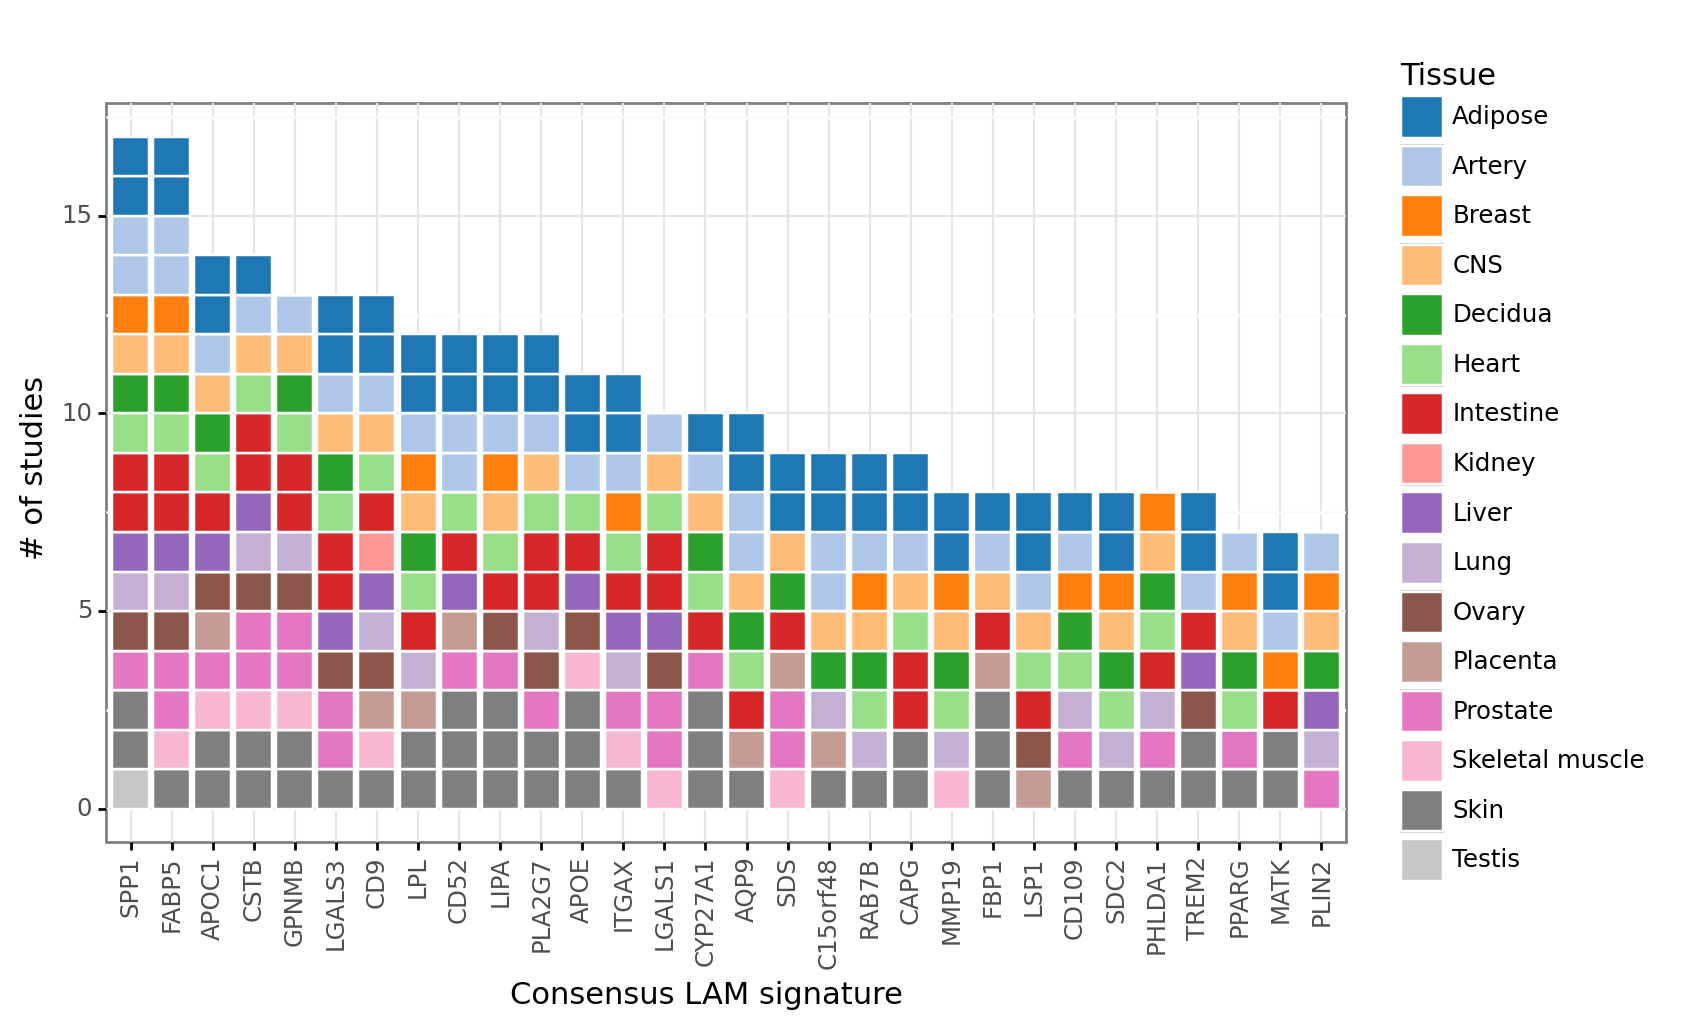

<ggplot: (8747457076758)>

In [108]:
from plotnine import *

g = (
    ggplot(aes(x='names', y='exists'), data=x) + 
    geom_col(aes(fill='tissue'), color='white', position='stack') +
    labs(x='Consensus LAM signature', y='# of studies', title='', fill='Tissue') +
    scale_fill_cmap_d('tab20') + theme_bw() + theme(figure_size=(8,4.8), axis_text_x=element_text(angle=90, face='italic'), text=element_text(color='black'))
)

g